# Deep Learning &mdash; Assignment 6

Sixth assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_October 2020_

-----

**Names:**
Enrico Schmitz (s1047521) & Charlotte Cambier van Nooten (s1044122)

**Group:**
Group 22

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational auto encoder
2. Extend the model to a conditional VAE


## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l
!pip install torch
!pip install torchvision

In [2]:
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 6.1 MNIST dataset

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divded over 10 classes.

In [3]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Run the code to load the MNIST dataset.**

## 6.2 Variational Auto Encoder


We will implement a Variational Auto Encoder. This model consists of two networks, an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**Complete the implementation below**

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # Choose an appropriate activation function for the final layer.
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z).to(device)
        eps = torch.randn_like(std_z).to(device)
        # Turn the sample ε from N(0,1) into a sample from N(μ,σ)
        esp_z = torch.randn(*mean_z.size()).to(device)
        z = mean_z + std_z * esp_z
        return z.to(device)

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for it.  
**What can go wrong if the decoder network directly outputs σ?**

If you don't apply a logarithm the values can get extremely large leading to a very big z.



## 6.3 Loss function

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we use binary cross entropy for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf)

**Implement the KL loss term below**

In [5]:
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def kl_loss(mean_z, logvar_z):
    KL = -0.5 * torch.sum(1 + logvar_z - mean_z**2 - torch.exp(logvar_z))
    return KL

def loss_function(recon_x, x, mean_z, logvar_z):
    l_r = reconstruction_loss(recon_x, x)
    l_kl = kl_loss(mean_z, logvar_z)
    return l_r + l_kl, l_r, l_kl

## 6.4 Training our VAE

**Complete the training loop below**

In [6]:
def train(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device)
            optimizer.zero_grad()
            # Compute the outputs and loss
            recognition_images, mean, logvar_z = model(X)
            loss, loss_r, loss_kl = loss_function(recognition_images, X, mean, logvar_z)
            # Optimize
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X = X.to(device)
            # Compute the outputs and loss
            recognition_images, mean, logvar_z = model(X)
            loss, loss_r, loss_kl = loss_function(recognition_images, X, mean, logvar_z)
            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

**Train the model**

training loss 155.297, test loss 155.037
training reconstruction loss 149.297, test reconstruction loss 148.881
training KL loss 6.000, test KL loss 6.156


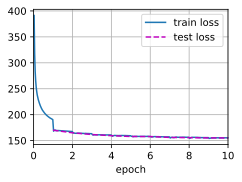

In [7]:
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

training loss 158.830, test loss 158.743
training reconstruction loss 152.941, test reconstruction loss 152.846
training KL loss 5.889, test KL loss 5.897


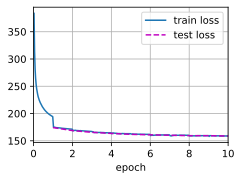

In [8]:
device = d2l.try_gpu()
model_l4 = VAE(latent_size=4).to(device)
train(model_l4)

**If you increase the numer of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?**

When increasing the latent dimensions, the total loss and the reconstruction loss are decreasing but the KL loss is increasing. So, the difference of the distributions is higher but the total loss is lower.


## 6.5 Visualizing the latent space

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**Complete the code below and run it to plot the latent space.**

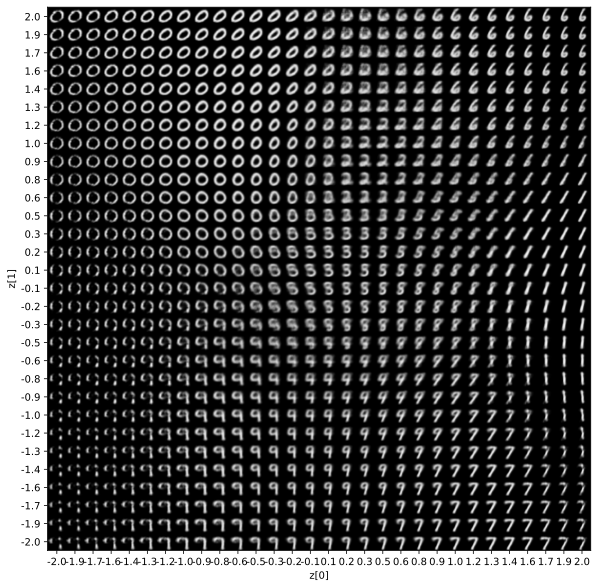

In [9]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Run the decoder on z = [xi,yi].
            z = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range #+ 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(model)

**Would it be possible to classify digits based on this latent representation?**

Yes, but classifying the digits will be easier when looking at the borders of this latent representation. In the middle, classifying will be more difficult. 



**If you retrain the model, would you expect the latent space to look the same. If not, what differences can you expect?**

In the function 'sample_latent' we make use of random values, due to this the samples will be random and latent space will look different everytime the model is retrained. 
See below for an example, we can see there that latent space is looking different.


training loss 176.120, test loss 174.459
training reconstruction loss 172.675, test reconstruction loss 171.029
training KL loss 3.445, test KL loss 3.431


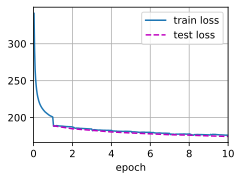

In [10]:
device = d2l.try_gpu()
practice_model = VAE().to(device)
train(practice_model)

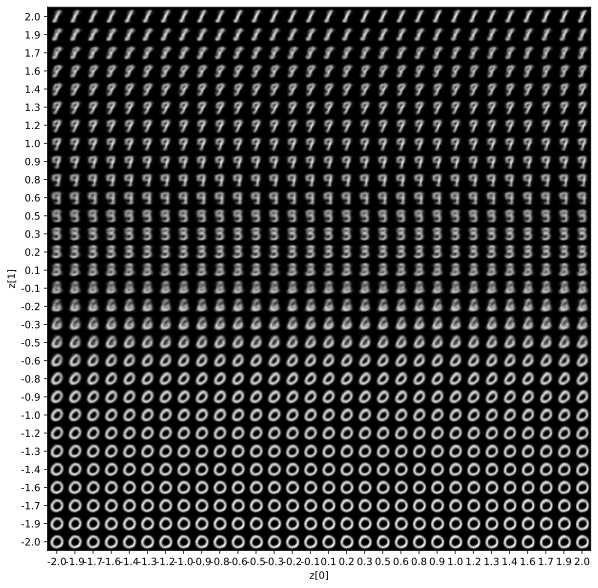

In [11]:
plot_latent(practice_model)

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**Complete and run the code below to make a scatterplot of the training data**

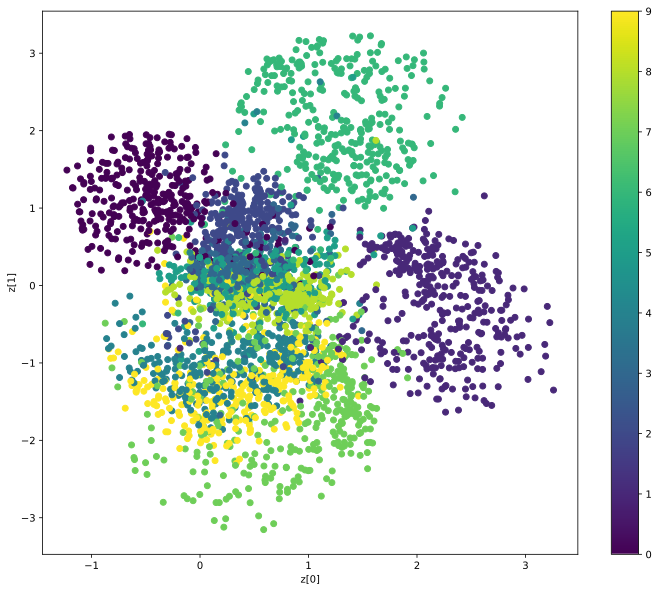

In [12]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        X = X.to(device)
        if i > 100: # Limit to a few batches to save memory
            break
        # Compute mean z
        z_mean,_ = model.encode(X)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()

    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(model)

**Compare this figure to the previous one, what do you notice?**

As said previous, classifying around the border will be easier, we can also see that from the scatterplot, in the middle points of different classes lay together.


**Look at the distribution of the data in the latent space. What distribution do you expect it to have based on the theory? Does the plot match this?**

Using the normal distribution, the KL divergence in the variational loss can be evaluated. This can be handy when using an efficent way for computing gradients. When having a gaussian distribution, it is easy to sample to samples in the latent space. The decoder doesn't require a certain distribution, due to non-linearity. 
When looking at the scatter plot, we can see that it is more difficult to classify the classes 3,5 in the latent space, and for 0,1 and 6 it is easier. 



## 6.6 Conditional Variational Autoencoder

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this conditional VAE, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z * z + W_y * y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**Complete the implementation of the conditional VAE below**

In [13]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # Split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input

        self.encoder_part1_x = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),
        )

        self.encoder_part1_y = nn.Sequential(
            nn.Linear(num_classes, 14*14),
        )

        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU(),
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # Add layer to use with the y input
        self.decoder_part1_y = nn.Linear(num_classes, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.Sigmoid(),    
        )

    def encode(self, x, y):      
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z).to(device)
        eps = torch.randn_like(std_z).to(device)
        esp_z = torch.randn(*mean_z.size()).to(device)
        z = mean_z + std_z * esp_z
        return z.to(device)

    def decode(self, z, y):
        # Use a first layer that combines z and y
        h = (self.decoder_part1_z(z) + self.decoder_part1_y(y)).reshape((-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**Copy the training code from section 6.4, and modify it for a conditional VAE**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [14]:
def train_cvae(model, num_epochs = 10, nclasses=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device)
            y = F.one_hot(y,nclasses).float().to(device)
            optimizer.zero_grad()
            # Compute the outputs and loss
            recognition_images, mean, logvar_z = model(X,y)
            loss, loss_r, loss_kl = loss_function(recognition_images, X, mean, logvar_z)
            # Optimize
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test_cvae(model, nclasses)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test_cvae(model, nclasses=10):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        lastrun = len(test_iter)-1
        for i, (X, y) in enumerate(test_iter):
            if (i < lastrun):
              X = X.to(device)
              y = F.one_hot(y,nclasses).float().to(device)
              # Compute the outputs and loss
              recognition_images, mean, logvar_z = model(X,y)
              loss, loss_r, loss_kl = loss_function(recognition_images, X, mean, logvar_z)
              metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

**Train a conditional VAE**

training loss 149.738, test loss 149.556
training reconstruction loss 147.290, test reconstruction loss 147.152
training KL loss 2.449, test KL loss 2.404


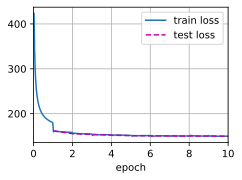

In [15]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**Adapt the `plot_latent` function from section 6.5 for conditional VAEs and use your function to visualize the latent space for a few classes.**

In [16]:
def plot_latent(model, nclasses=10):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    y = torch.randint(0, nclasses, (1, 1)).to(dtype=torch.long)
    print(f'Generating a {y.item()}')
    y = F.one_hot(y,10).float().to(device)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Run the decoder on z = [xi,yi].
            z = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z,y)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range 
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


training loss 134.158, test loss 134.590
training reconstruction loss 129.290, test reconstruction loss 129.647
training KL loss 4.868, test KL loss 4.943


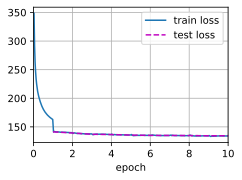

In [17]:
cvae_model_1 = ConditionalVAE(num_classes=10).to(device)
train_cvae(cvae_model_1, nclasses=10)

Generating a 4


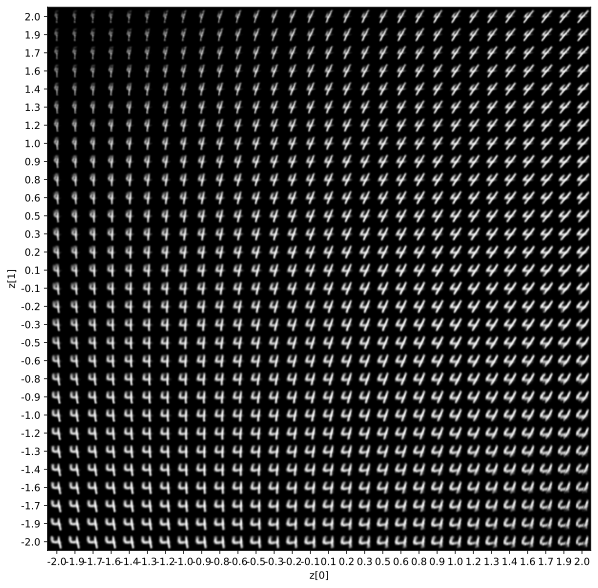

In [18]:
plot_latent(cvae_model_1)

Generating a 3


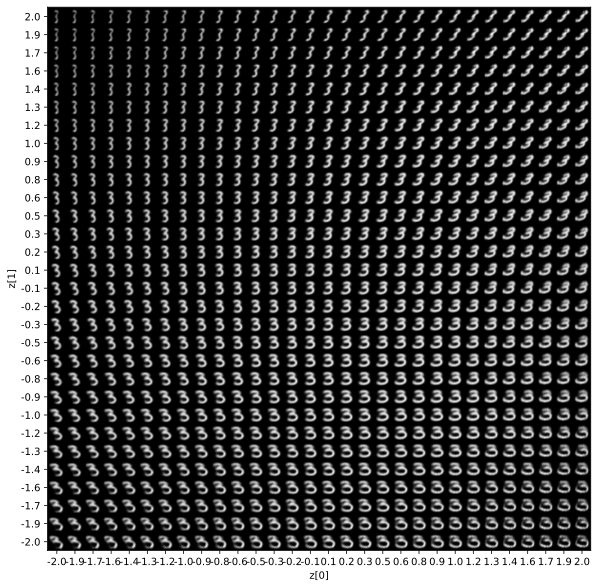

In [19]:
plot_latent(cvae_model_1)

Generating a 9


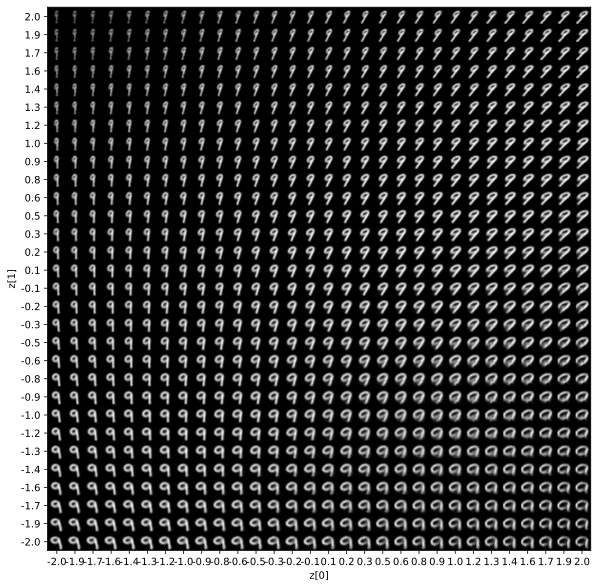

In [20]:
plot_latent(cvae_model_1)

**What do the latent dimensions represent? Is this the same for all labels?**

The latent dimensions, give for each plot small images of numbers in the upper left, from that corner it's getting bigger, but in the bottom right corner, images are stretched out (for all labels)



**Adapt `scatterplot_latent` to show the distribution in the latent space.**

In [21]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        if i > 100: # Limit to a few batches to save memory
            break
        X = X.to(device)
        yi = F.one_hot(y,10).float().to(device)
        # Compute mean z
        z_mean,_ = model.encode(X,yi)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()

    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

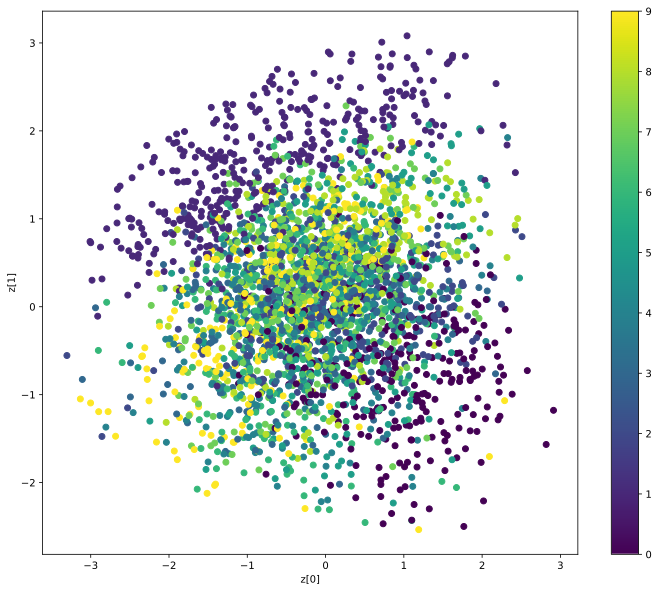

In [22]:
scatterplot_latent(cvae_model_1)

**How is this distribution different from the distribution of the VAE? Does this match the theory?**

When using the ConditionalVAE, the estimated posterior (Q(z|x,y)) is in this case coditioned on the different classes. When using the latent space, it has no added value to seperate classes from input, this has already been done. 

**Would it be possible to classify digits based on the latent representation of the conditional VAE?**

In the area of points, the edges may be classified by the latent representation of the CVEA. In the middle this isn't possible. 


**How would you use a conditional VAE to change the label of an image, while keeping everything else as similar as possible?**

First obtain the vector (latent representation) $z$. When using $z$ we can decode various outputs with different labels from the original label

## 6.7 Discussion

**Is the conditional VAE a strict improvement over the normal VAE in all cases?**

The reconstruction loss is better when using ConditionalVAE. When using the normal VAE, we had no influence on how the data was generated. When generating a specific dataset, we would prefer to use the CVAE. CVAE enables to sample under a specific label.



**Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. Are they the same thing?**

Yes, there are similair, ouptut of encoder ($z$) of VAE can be used as input in a generator of the GAN. 

VAE/GAN are a combinations between the two models. 


## The end

Well done! Please double check the instructions at the top before you submit your results.